In [ ]:
# %load init.ipy
# NOTE: This is for when the notebook is converted to a python script
# NOTE: this MUST precede the magic functions
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))
    
%reload_ext autoreload
%autoreload 2

# %load init.ipy
import os, sys, logging, datetime
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import corner
import tqdm
import memory_profiler as mpro

import kalepy as kale
import kalepy.utils
import kalepy.plot
from kalepy.plot import nbshow   # NOTE: this should be upgraded to `plot_control`
from kalepy.plot import plot_control

def save_fig(fig, fname, **kwargs):
    kwargs.setdefault('path', kale._PATH_NB_OUT)
    kwargs.setdefault('rename', True)
    return kale.plot.save_fig(fig, fname, **kwargs)

## Cholesky Whitening and Coloring

data:
[[6.33718263 3.50318782]
 [3.50318782 2.3710603 ]]
[[ 0.97895145 -0.03267041]
 [-0.03267041  1.05380458]]
clean:
[[0.92678867 0.00103601]
 [0.00103601 1.00500592]]
[[5.79242917 3.1296052 ]
 [3.1296052  2.1205413 ]]


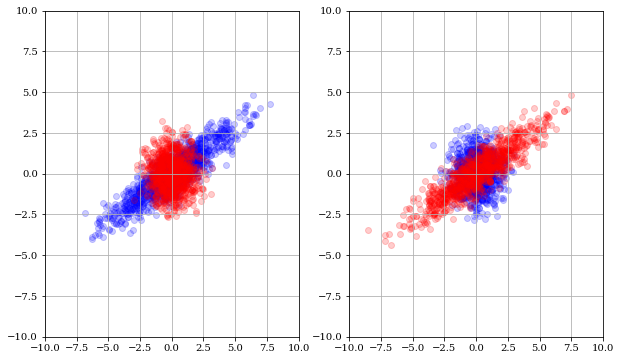

In [2]:
NUM = 1000

sigma = [2.5, 1.5]
corr = 0.9

s2 = np.square(sigma)
cc = corr*sigma[0]*sigma[1]
cov = [[s2[0], cc], [cc, s2[1]]]

cov = np.array(cov)
cov_inv = np.linalg.inv(cov)
color = sp.linalg.cholesky(cov)
white = sp.linalg.cholesky(cov_inv)

data = np.random.multivariate_normal([0.0, 0.0], cov, NUM).T
clean = np.random.multivariate_normal([0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]], size=NUM).T

norm = np.sqrt(np.linalg.det(2*np.pi*cov))

data_inv = np.dot(white, data)
clean_col = np.dot(color.T, clean)


print("data:")
print(np.cov(*data))
print(np.cov(*data_inv))

print("clean:")
print(np.cov(*clean))
print(np.cov(*clean_col))



fig, axes = plt.subplots(figsize=[10, 6], ncols=2)
for ax in axes:
    ax.set(xlim=[-10, 10], ylim=[-10, 10])
    ax.grid()

ax = axes[0]
ax.scatter(*data, alpha=0.2, color='b')
ax.scatter(*data_inv, alpha=0.2, color='r')

ax = axes[1]
ax.scatter(*clean, alpha=0.2, color='b')
ax.scatter(*clean_col, alpha=0.2, color='r')

nbshow()

[[1.  0.4]
 [0.4 1. ]]
norm =  0.9573479717381596
clean:
[[ 0.33129266 -0.00287213]
 [-0.00287213  0.33293846]]
color:
[[0.36146992 0.14171584]
 [0.14171584 0.36068062]]
test:
[[0.41708542 0.28625907]
 [0.28625907 0.41859383]]


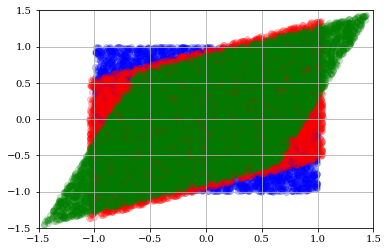

In [3]:
NUM = 10000

sigma = [1.0, 1.0]
corr = 0.4

s2 = np.square(sigma)
cc = corr*sigma[0]*sigma[1]
cov = [[s2[0], cc], [cc, s2[1]]]

cov = np.array(cov)
print(cov)

cov_inv = np.linalg.inv(cov)
color_mat = sp.linalg.cholesky(cov)
# white_mat = sp.linalg.cholesky(cov_inv)
norm = np.sqrt(np.linalg.det(color_mat))
print("norm = ", norm)

clean_data = np.random.uniform(-1.0, 1.0, size=2*NUM).reshape(2, NUM)

# data_inv = np.dot(white, data)
color_data = np.dot(color_mat.T, clean_data) / norm
test_data = np.dot(cov, clean_data) / norm

print("clean:")
print(np.cov(*clean_data))
print("color:")
print(np.cov(*color_data))
print("test:")
print(np.cov(*test_data))


fig, ax = plt.subplots()   # figsize=[10, 6], ncols=2)
ax.set(xlim=[-1.5, 1.5], ylim=[-1.5, 1.5])
ax.grid()

ax.scatter(*clean_data, alpha=0.2, color='b')
ax.scatter(*color_data, alpha=0.2, color='r')
ax.scatter(*test_data, alpha=0.2, color='g')

nbshow()

[[2.25  1.575]
 [1.575 2.25 ]] 

data_cov = 
 [[2.26354411 1.58680498]
 [1.58680498 2.261147  ]]
uncolor_cov = 
 [[1.00601961 0.0014464 ]
 [0.0014464  1.00109511]]
recolor_cov = 
 [[2.26354411 1.58680498]
 [1.58680498 2.261147  ]]


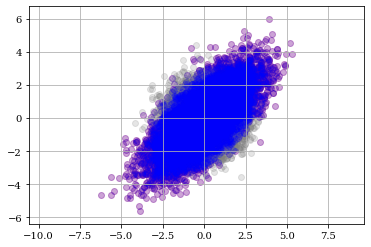

In [4]:
NUM = 10000

sigma = [1.5, 1.5]
corr = 0.7

s2 = np.square(sigma)
cc = corr*sigma[0]*sigma[1]
cov = [[s2[0], cc], [cc, s2[1]]]

cov = np.array(cov)
print(cov, "\n")

color_mat = sp.linalg.cholesky(cov)
color_norm = np.sqrt(np.linalg.det(color_mat))
# print("color_norm = ", color_norm)

uncolor_mat = np.linalg.inv(color_mat)
uncolor_norm = np.sqrt(np.linalg.det(uncolor_mat))
# print("uncolor_norm = ", uncolor_norm)

cov_inv = np.linalg.inv(cov)
white_mat = sp.linalg.cholesky(cov_inv)
white_norm = np.sqrt(np.linalg.det(white_mat))
# print("white_norm = ", white_norm)




data = np.random.multivariate_normal(np.zeros(2), cov, NUM).T
data_cov = np.cov(*data)
print("data_cov = \n", data_cov)

uncolor_data = np.dot(uncolor_mat.T, data) # / uncolor_norm
uncolor_cov = np.cov(*uncolor_data)
print("uncolor_cov = \n", uncolor_cov)

# recolor_data = np.dot(cov, data) # / color_norm
# recolor_cov = np.cov(*recolor_data)
# print("recolor_cov = \n", recolor_cov)


# DOES NOT WORK
recolor_data = np.dot(color_mat.T, uncolor_data) # / color_norm
recolor_cov = np.cov(*recolor_data)
print("recolor_cov = \n", recolor_cov)




# white_data = np.dot(white_mat, data) # / uncolor_norm
# white_cov = np.cov(*white_data)
# print("white_cov = \n", white_cov)


# white_data = np.dot(white_mat, data) / white_norm
# white_cov = np.cov(*white_data)
# print("white_cov = ", white_cov)

# unwhite_data = np.dot(color_mat.T, white_data) / color_norm
# unwhite_cov = np.cov(*unwhite_data)
# print("unwhite_cov = ", unwhite_cov)

# data_inv = np.dot(white, data)
# color_data = np.dot(color_mat.T, clean_data) / norm
# test_data = np.dot(cov, clean_data) / norm

# print("clean:")
# print(np.cov(*clean_data))
# print("color:")
# print(np.cov(*color_data))
# print("test:")
# print(np.cov(*test_data))


fig, ax = plt.subplots()   # figsize=[10, 6], ncols=2)
# ax.set(xlim=[-1.5, 1.5], ylim=[-1.5, 1.5])
ax.grid()
ax.axis('equal')


ax.scatter(*data, alpha=0.2, color='r')
ax.scatter(*uncolor_data, alpha=0.2, color='0.5')
ax.scatter(*recolor_data, alpha=0.2, color='b')

# ax.scatter(*white_data, alpha=0.2, color='g')
# ax.scatter(*unwhite_data, alpha=0.2, color='g')

nbshow()

[[1.  0.4]
 [0.4 1. ]]
data_cov = 
 [[ 0.33671914 -0.00413517]
 [-0.00413517  0.33049844]]
white_cov = 
 [[1.00000000e+00 3.37541554e-18]
 [3.37541554e-18 1.00000000e+00]]
color_cov = 
 [[1.  0.4]
 [0.4 1. ]]
test_cov = 
 [[0.33671914 0.13089771]
 [0.13089771 0.3284618 ]]


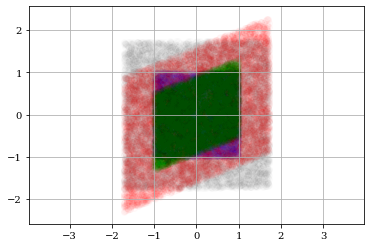

In [5]:
NUM = 10000

sigma = [1.0, 1.0]
corr = 0.4

s2 = np.square(sigma)
cc = corr*sigma[0]*sigma[1]
cov = [[s2[0], cc], [cc, s2[1]]]

cov = np.array(cov)
print(cov)

# cov_inv = np.linalg.inv(cov)
# color_mat = sp.linalg.cholesky(cov)
# white_mat = sp.linalg.cholesky(cov_inv)
# norm = np.sqrt(np.linalg.det(color_mat))
# print("norm = ", norm)

data = np.random.uniform(-1.0, 1.0, size=2*NUM).reshape(2, NUM)
data_cov = np.cov(*data)
print("data_cov = \n", data_cov)

color_mat = sp.linalg.cholesky(cov)
# print("color_mat = \n", color_mat)
white_mat = np.linalg.inv(sp.linalg.cholesky(data_cov))
# print("white_mat = \n", white_mat)
white_data = np.dot(white_mat.T, data)
white_cov = np.cov(*white_data)
print("white_cov = \n", white_cov)

color_data = np.dot(color_mat.T, white_data)
color_cov = np.cov(*color_data)
print("color_cov = \n", color_cov)

test_data = np.dot(color_mat.T, data)
test_cov = np.cov(*test_data)
print("test_cov = \n", test_cov)


fig, ax = plt.subplots()   # figsize=[10, 6], ncols=2)
# ax.set(xlim=[-1.5, 1.5], ylim=[-1.5, 1.5])
ax.axis('equal')
ax.grid()

ax.scatter(*data, alpha=0.02, color='b')
ax.scatter(*white_data, alpha=0.02, color='0.5')
ax.scatter(*color_data, alpha=0.02, color='r')
ax.scatter(*test_data, alpha=0.02, color='g')

nbshow()